In [1]:
import numpy as np
from scipy.stats import binom
from scipy.special import comb, gamma, kv
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
def gaussian_normalization(ell):
    # Integral of Gaussian covariance with lengthscale ell from 0 to infinity
    return np.sqrt(2 * np.pi * ell**2)

def matern_normalization(ell, nu):
    # Integral of Matern covariance with lengthscale ell from 0 to infinity
    return np.sqrt(2 * np.pi * ell**2) * gamma(nu + 0.5)/gamma(nu)/(nu**0.5)

def gaussian_covariance(x, ell=1.):
    x_normalized = x / ell
    return np.exp(-x_normalized**2/2)/gaussian_normalization(ell)

def matern_covariance(x, ell=1., nu=0.5):
    if np.isinf(nu): return gaussian_covariance(x,ell=ell)
    # Matern covariance with lengthscale ell    
    x[x == 0.0] += np.finfo(float).eps  # strict zeros result in nan
    x_normalized = np.sqrt(2*nu) * np.abs(x) / ell
    unnormalized_covar = (2**(1-nu) / gamma(nu)) * (x_normalized)**nu * kv(nu, x_normalized)
    return unnormalized_covar/matern_normalization(ell,nu)

def gaussian_spectrum(x):
    return np.exp(-x**2/2)/gaussian_normalization(1.)

In [3]:
matern_covariance(np.linspace(-5.,5.,5))

array([0.00336897, 0.0410425 , 0.5       , 0.0410425 , 0.00336897])

In [237]:
def matched_fill(xmax,order):
    k = 2*order+1
    #grid = np.linspace(-xmax,xmax,k)
    N=1000
    nyquist_w = np.pi*k/(2*xmax)
    dx = 2*xmax/N
    dw = 2*nyquist_w/N
    spatial_coverage = gaussian_covariance(np.linspace(-xmax,xmax,N)).sum()*dx
    spectral_coverage = gaussian_spectrum(np.linspace(-nyquist_w,nyquist_w,N)).sum()*dw
    return spatial_coverage-spectral_coverage
    #return np.sqrt(spatial_coverage*spectral_coverage)
    #return np.sqrt(spatial_coverage*spectral_coverage)

In [271]:
(-2<=np.linspace(-3,5,10))<=3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [244]:
def matched_fill(s,order):
    k = 2*order+1
    #grid = np.linspace(-xmax,xmax,k)
    N=1000
    a = s*k/2
    nyquist_w = np.pi/s
    dx = 2*a/N
    dw = 2*nyquist_w/N
    spatial_coverage = gaussian_covariance(np.linspace(-a,a,N)).sum()*dx
    spectral_coverage = gaussian_spectrum(np.linspace(-nyquist_w,nyquist_w,N)).sum()*dw
    return spatial_coverage-spectral_coverage

def binary_search(target,bounds,fn,eps=1e-2):
    lb,ub = bounds
    i = 0
    while ub-lb>eps:
        guess = (ub+lb)/2
        y = fn(guess)
        if y<target:
            lb = guess
        elif y>=target:
            ub = guess
        i+=1
        if i>500: assert False
    return (ub+lb)/2

In [10]:
def fill(xmax,order,nu=.5):
    """ computes the rectangle rule integration of matern with given spacing"""
    n = 2*order+1
    grid = np.linspace(-xmax,xmax,n)
    fx = matern_covariance(grid,nu=nu)
    dx = xmax/order
    return fx.sum()*dx
    #return np.trapz(fx,grid)

In [162]:
def fill2(xmax,order,nu=.5):
    """"""
    n = 2*order+1
    grid = np.linspace(-xmax,xmax,n)
    f_on_grid = matern_covariance(grid,nu=nu)
    upper = (1+.5/order)*xmax
    lower = -upper
    def discretized_fn(x):
        xbin = ((x - lower)//((upper-lower)/n)).astype(int)
        return np.where((xbin>=0)|(xbin<n),f_on_grid[xbin%n],np.zeros_like(x))
    N=10000
    finegrid = np.linspace(-10,10,N)
    ISE = ((matern_covariance(finegrid,nu=nu)-discretized_fn(finegrid))**2).mean()
    return ISE

In [245]:
def binary_search(target,bounds,fn,eps=1e-2):
    lb,ub = bounds
    i = 0
    while ub-lb>eps:
        guess = (ub+lb)/2
        y = fn(guess)
        if y<target:
            lb = guess
        elif y>=target:
            ub = guess
        i+=1
        if i>500: assert False
    return (ub+lb)/2

In [267]:
order=2
fn = partial(matched_fill,order=order)
s = binary_search(0,(.1,10),fn,1e-3)
print(s,fn(s))

1.1208770751953123 -9.450015611589535e-06


In [259]:
print(xf*(1-1/(2*order+1)))

1.15773681640625


In [260]:
xf = xf*(1-1/(2*order+1))#*np.sqrt((2*order+1)/4)
#xf = np.sqrt(np.pi/2)

In [274]:
import torch
torch.arange(-4,5)*.2

tensor([-0.8000, -0.6000, -0.4000, -0.2000,  0.0000,  0.2000,  0.4000,  0.6000,
         0.8000])

In [268]:

ci = gaussian_covariance(np.linspace(-order*s,order*s,2*order+1))
print(ci/ci[order])
print(ci/ci[0])

[0.08104661 0.53356056 1.         0.53356056 0.08104661]
[ 1.          6.58337892 12.33857872  6.58337892  1.        ]


In [263]:
np.linspace(-s*(order+.5),s*(order+.5),2*order+1)

array([-2.80219269, -1.40109634,  0.        ,  1.40109634,  2.80219269])

In [236]:
def var(cs):
    o = len(cs)//2
    cs = cs/cs.sum()
    return (2*cs[o+1:]*(1+np.arange(o))**2).sum()
print(var(ci))

0.7694065900810181


In [104]:
xf = np.sqrt(np.pi/2)
ci = gaussian_covariance(np.linspace(-xf,xf,2*order+1))
print(ci/ci[order])

[0.45593813 1.         0.45593813]


In [87]:
np.sqrt(np.pi*3/2)

2.1708037636748028

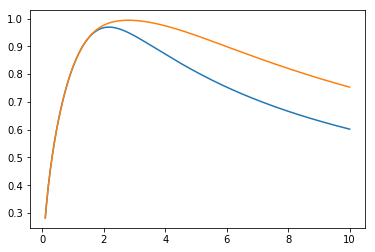

In [207]:
X = np.linspace(.1,10,300)
plt.plot(X,[matched_fill(x,1) for x in X])
plt.plot(X,[matched_fill(x,2) for x in X])

In [210]:
x1 = X[np.argmax([matched_fill(x,1) for x in X])]
x2 = X[np.argmax([matched_fill(x,2) for x in X])]
x1 = x1*(1-1/3)
x2 = x2*(1-1/5)
print(x1,x2)

1.4573021181716836 2.2520401337792646


In [59]:
X = np.linspace(.1,10,300)
Y = [matched_fill(x,1) for x in X]
X[np.argmax(Y)]

1.7886287625418062

(-0.0008734489862663461, 0.10212655101373366)

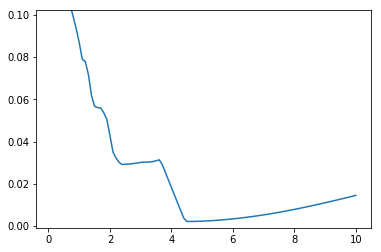

In [169]:
X = np.linspace(.1,10,100)
Y = np.array([fill2(x,2,nu=np.inf) for x in X])
plt.plot(X,Y)
plt.ylim(Y.min()-3e-3,Y.min()+1e-1)

In [145]:
X[np.argmin(Y)]

2.7

In [14]:
def binary_search(objective,bounds):
    lb,ub = bounds
    

0.06312530404709249